# Capstone Final Project

#### The first thing to do is import all relevant dependencies

In [502]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes  #Only if it hasn't been installed before
import folium # map rendering library

import math

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

!pip install haversine
import haversine as hs

!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

#### Then, we download the table with the coordinates of the New York neighborhoods.

In [503]:
ny_coord_site = "https://data.cityofnewyork.us/api/views/xyye-rtrs/rows.csv?accessType=DOWNLOAD"

ny_coord_df = pd.read_csv(ny_coord_site)

ny_coord_df.head()

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough
0,POINT (-73.8472005205491 40.89470517661004),1,Wakefield,1,Wakefield,NaN,NaN,0,Bronx
1,POINT (-73.82993910812405 40.87429419303015),2,Co-op City,2,Co-op,City,NaN,0,Bronx
2,POINT (-73.82780644716419 40.88755567735082),3,Eastchester,1,Eastchester,NaN,NaN,0,Bronx
3,POINT (-73.90564259591689 40.895437426903875),4,Fieldston,1,Fieldston,NaN,NaN,0,Bronx
4,POINT (-73.91258546108577 40.89083449389134),5,Riverdale,1,Riverdale,NaN,NaN,0,Bronx


#### As we can see, the latitude and longitude are in the same column, so we have to separate them.

In [504]:
ny_coord_df["the_geom"] = ny_coord_df["the_geom"].str.replace("(","").str.replace(")","").str.split(" ")
ny_coord_df["Longitude"] = ny_coord_df["the_geom"].str[1].str.replace(" ","")
ny_coord_df["Latitude"] = ny_coord_df["the_geom"].str[2].str.replace(" ","")
ny_coord_df.head()

,the_geom,OBJECTID,Name,Stacked,AnnoLine1,AnnoLine2,AnnoLine3,AnnoAngle,Borough,Longitude,Latitude
0,"[POINT, -73.8472005205491, 40.89470517661004]",1,Wakefield,1,Wakefield,NaN,NaN,0,Bronx,-73.8472005205491,40.89470517661004
1,"[POINT, -73.82993910812405, 40.87429419303015]",2,Co-op City,2,Co-op,City,NaN,0,Bronx,-73.82993910812405,40.87429419303015
2,"[POINT, -73.82780644716419, 40.88755567735082]",3,Eastchester,1,Eastchester,NaN,NaN,0,Bronx,-73.82780644716419,40.88755567735082
3,"[POINT, -73.90564259591689, 40.895437426903875]",4,Fieldston,1,Fieldston,NaN,NaN,0,Bronx,-73.90564259591689,40.895437426903875
4,"[POINT, -73.91258546108577, 40.89083449389134]",5,Riverdale,1,Riverdale,NaN,NaN,0,Bronx,-73.91258546108577,40.89083449389134


#### We clean the dataframe dropping all the columns that we don't need.

In [505]:
ny_coord_df.drop(["the_geom","OBJECTID","Stacked","AnnoLine1","AnnoLine2","AnnoLine3","AnnoAngle","Borough"], axis = 1, inplace=True)
ny_coord_df.rename(columns={"Name":"Neighborhood"}, inplace=True)
ny_coord_df.head()

,Neighborhood,Longitude,Latitude
0,Wakefield,-73.8472005205491,40.89470517661004
1,Co-op City,-73.82993910812405,40.87429419303015
2,Eastchester,-73.82780644716419,40.88755567735082
3,Fieldston,-73.90564259591689,40.895437426903875
4,Riverdale,-73.91258546108577,40.89083449389134


#### Finally, we convert the longitude and latitude to floats, given that they were strings.

In [506]:
ny_coord_df = ny_coord_df.astype({"Longitude": "float32", "Latitude":"float32"})
ny_coord_df.head()

,Neighborhood,Longitude,Latitude
0,Wakefield,-73.847198,40.894707
1,Co-op City,-73.829941,40.874294
2,Eastchester,-73.827805,40.887554
3,Fieldston,-73.905640,40.895439
4,Riverdale,-73.912582,40.890835


#### How many neighborhoods are in the dataframe?

In [509]:
print("The coordinates dataframe has {} neighborhoods".format(ny_coord_df.shape[0]))

The coordinates dataframe has 299 neighborhoods


#### Now, we download the table with the rent rates for the neighborhoods of New York.

In [510]:
site = "https://streeteasy-market-data-download.s3.amazonaws.com/rentals/All/medianAskingRent_All.zip"

ny_rent = pd.read_csv(site)

ny_rent.head()

,areaName,Borough,areaType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,...,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07
0,All Downtown,Manhattan,submarket,3200.0,3200.0,3025.0,3100.0,3100.0,3200.0,3195.0,3200.0,3400.0,3495.0,3450.0,3400.0,3365.0,3395.0,3300.0,3300.0,3395.0,3400.0,3395.0,3495.0,3625.0,3670.0,3550.0,3495.0,3450.0,3450.0,3500.0,3500.0,3575.0,3550.0,3500.0,3550.0,3650.0,3600.0,3675.0,3670.0,3550.0,...,3714.0,3790.0,3725.0,3725.0,3700.0,3667.0,3665.0,3675.0,3644.0,3650.0,3750.0,3737.0,3759.0,3844.0,3800.0,3799.0,3800.0,3825.0,3800.0,3866.0,3800.0,3800.0,3859.0,3800.0,3939.0,4000.0,4075.0,4000.0,3995.0,4000.0,4057.0,4085.0,4022.0,4000.0,4000.0,4000.0,3896.0,3750.0,3695.0,3595.0
1,All Midtown,Manhattan,submarket,2875.0,2800.0,2800.0,2850.0,2895.0,2950.0,3000.0,3000.0,3100.0,3100.0,3150.0,3150.0,3160.0,3198.0,3195.0,3200.0,3250.0,3300.0,3335.0,3300.0,3350.0,3375.0,3395.0,3350.0,3300.0,3250.0,3250.0,3320.0,3395.0,3395.0,3395.0,3400.0,3400.0,3400.0,3440.0,3450.0,3400.0,...,3500.0,3500.0,3530.0,3500.0,3500.0,3500.0,3500.0,3350.0,3350.0,3387.0,3400.0,3390.0,3450.0,3500.0,3500.0,3500.0,3500.0,3504.0,3535.0,3500.0,3550.0,3500.0,3550.0,3540.0,3587.0,3632.0,3680.0,3700.0,3710.0,3700.0,3692.0,3715.0,3700.0,3700.0,3700.0,3700.0,3600.0,3450.0,3320.0,3240.0
2,All Upper East Side,Manhattan,submarket,2460.0,2450.0,2400.0,2500.0,2550.0,2550.0,2595.0,2500.0,2595.0,2550.0,2500.0,2550.0,2500.0,2500.0,2450.0,2500.0,2600.0,2695.0,2650.0,2695.0,2795.0,2800.0,2800.0,2800.0,2700.0,2700.0,2695.0,2695.0,2695.0,2750.0,2700.0,2750.0,2850.0,2795.0,2850.0,2850.0,2795.0,...,2950.0,2950.0,2950.0,2950.0,2900.0,2995.0,2943.0,2991.0,2980.0,2900.0,2895.0,2850.0,2848.0,2850.0,2900.0,2910.0,2900.0,2895.0,2995.0,2995.0,3000.0,3000.0,3000.0,2995.0,2993.0,3000.0,3050.0,3050.0,2995.0,3000.0,3100.0,3250.0,3300.0,3295.0,3275.0,3255.0,3200.0,3095.0,2995.0,2888.0
3,All Upper Manhattan,Manhattan,submarket,1836.0,1800.0,1795.0,1800.0,1823.0,1850.0,1875.0,1850.0,1898.0,1875.0,1850.0,1850.0,1850.0,1800.0,1875.0,1895.0,1920.0,1950.0,1950.0,1976.0,1995.0,1985.0,1995.0,2000.0,2000.0,2000.0,2000.0,2000.0,1995.0,1963.0,2000.0,2050.0,2000.0,1995.0,2000.0,2000.0,1980.0,...,2325.0,2350.0,2350.0,2395.0,2395.0,2354.0,2350.0,2256.0,2295.0,2265.0,2295.0,2300.0,2350.0,2383.0,2399.0,2429.0,2400.0,2350.0,2350.0,2300.0,2300.0,2300.0,2333.0,2375.0,2400.0,2450.0,2500.0,2500.0,2495.0,2445.0,2395.0,2350.0,2350.0,2387.0,2400.0,2475.0,2495.0,2475.0,2475.0,2495.0
4,All Upper West Side,Manhattan,submarket,2895.0,2800.0,2750.0,2800.0,2800.0,2795.0,2800.0,2895.0,2995.0,3050.0,3000.0,2995.0,2995.0,3000.0,2950.0,3000.0,3000.0,3100.0,3100.0,3200.0,3250.0,3344.0,3388.0,3475.0,3300.0,3200.0,3045.0,3150.0,3200.0,3200.0,3250.0,3300.0,3325.0,3350.0,3350.0,3300.0,3200.0,...,3300.0,3350.0,3380.0,3390.0,3395.0,3395.0,3395.0,3325.0,3350.0,3350.0,3295.0,3250.0,3293.0,3317.0,3350.0,3350.0,3330.0,3400.0,3395.0,3392.0,3400.0,3400.0,3350.0,3400.0,3458.0,3490.0,3462.0,3400.0,3500.0,3625.0,3600.0,3650.0,3572.0,3650.0,3591.0,3570.0,3471.0,3325.0,3250.0,3208.0


#### We drop the columns we don't need and use an average of the wanted period. Also, we have to rename the areaName column to make it the same as in the coordinates dataframe.

In [511]:
ny_rent.drop(ny_rent.columns[1:len(ny_rent.columns)-21] , inplace =True, axis=1)
ny_rent["Rent for Two-bedroom"] = round(ny_rent.mean(axis=1))

ny_rent.drop(ny_rent.columns[1:len(ny_rent.columns)-1] , inplace =True, axis=1)

ny_rent.rename(columns = {"areaName":"Neighborhood"}, inplace = True)

ny_rent.head()

,Neighborhood,Rent for Two-bedroom
0,All Downtown,3916.0
1,All Midtown,3594.0
2,All Upper East Side,3082.0
3,All Upper Manhattan,2414.0
4,All Upper West Side,3465.0


#### How many neighborhoods has the rent dataframe?

In [512]:
print("The rent dataframe has {} neighborhoods".format(ny_rent.shape[0]))

The rent dataframe has 198 neighborhoods


#### Now that we have both dataframes, we can merge them into one.

In [513]:
ny_df = ny_rent.merge(ny_coord_df,how="right")
ny_df.head()

,Neighborhood,Rent for Two-bedroom,Longitude,Latitude
0,Astoria,2273.0,-73.915657,40.768509
1,Auburndale,1971.0,-73.791763,40.761730
2,Bath Beach,1781.0,-73.998749,40.599518
3,Battery Park City,4645.0,-74.016869,40.711933
4,Bay Ridge,1963.0,-74.030624,40.625801


#### How many neighborhoods are in the New York dataframe?

In [514]:
print("The New York dataframe has {} neighborhoods".format(ny_df.shape[0]))

The New York dataframe has 299 neighborhoods


#### We define the a user_agent, called *ny_explorer*, to define an instance of the geocoder.

In [515]:
address = 'Manhattan, New York, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude_ny = location.latitude
longitude_ny = location.longitude
print('The geograpical coordinates of Manhattan, New York are {}, {}.'.format(latitude_ny, longitude_ny))

The geograpical coordinates of Manhattan, New York are 40.7896239, -73.9598939.


#### We create a map of New York with the Neighborhoods and rates superimposed.

In [516]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

# add markers to map
for lat, lng, neighborhood, rent in zip(ny_df['Latitude'], ny_df['Longitude'], ny_df['Neighborhood'],  ny_df['Rent for Two-bedroom']):
    label = '{}, Rent: ${}'.format(neighborhood, rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ny)  
    
map_ny

#### Now that we are done with New York, we fly across the Atlantic to London. We are going to perform the same steps as we did with New York.

#### We download the rent rates table.

In [517]:
pc_site = "https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/838298/GLA_2019_Q3.xlsx"

lon_rates_pc = pd.read_excel(pc_site, sheet_name ="Table 1.3", skiprows=12, skipfooter=41)

lon_rates_pc.head()

,Unnamed: 0,Postcode District,Bedroom Category,Count of rents,Mean,Lower quartile,Median,Upper quartile
0,NaN,BR1,Room,10,534,492,542,592
1,NaN,BR1,Studio,10,724,600,740,813
2,NaN,BR1,One Bedroom,120,1014,950,1000,1100
3,NaN,BR1,Two Bedrooms,230,1220,1100,1200,1330
4,NaN,BR1,Three Bedrooms,100,1459,1350,1450,1600


#### We keep only the mean rent for the Two Bedroom apartments.

In [518]:
lon_rates_pc = lon_rates_pc[lon_rates_pc["Bedroom Category"] == "Two Bedrooms"]
lon_rates_pc.drop(["Unnamed: 0", "Bedroom Category", "Count of rents", "Lower quartile", "Median", "Upper quartile"], axis = 1, inplace = True)
lon_rates_pc.reset_index(drop= True, inplace = True)
lon_rates_pc

,Postcode District,Mean
0,BR1,1220
1,BR2,1251
2,BR3,1235
3,BR4,1095
4,BR5,1097
...,...,...
324,WC99,.
325,WD2,.
326,WD23,.
327,WD3,.


#### We drop all the rows in which the mean is not a number.

In [519]:
lon_rates_pc.replace(to_replace = ".", value=math.nan, inplace=True)
lon_rates_pc.replace(to_replace = "..", value=math.nan, inplace=True)
lon_rates_pc.dropna(inplace=True)
lon_rates_pc.reset_index(inplace=True, drop=True)
lon_rates_pc

,Postcode District,Mean
0,BR1,1220.0
1,BR2,1251.0
2,BR3,1235.0
3,BR4,1095.0
4,BR5,1097.0
...,...,...
227,WC1B,2716.0
228,WC1E,2557.0
229,WC1H,2395.0
230,WC1R,2060.0


#### Since we are only going to use the neighborhoods of Inner London, we drop everything else.

In [520]:
inner_lon_pc_list = ["E", "EC", "N", "NW", "SE", "SW", "W", "WC"]
outer_lon_pc_list = ["BR", "CM", "CR", "DA", "EN", "HA", "IG", "SL", "TN", "KT", "RM", "SM", "TW", "UB", "WD"]

aux_df = pd.DataFrame()

for inner in inner_lon_pc_list:
  aux_df = aux_df.append(lon_rates_pc[lon_rates_pc["Postcode District"].str.startswith(inner)])

lon_rates_pc = aux_df

for outer in outer_lon_pc_list:
  lon_rates_pc = lon_rates_pc[~lon_rates_pc["Postcode District"].str.startswith(outer)]

lon_rates_pc.reset_index(drop=True, inplace=True)

lon_rates_pc

,Postcode District,Mean
0,E1,2152.0
1,E10,1345.0
2,E11,1335.0
3,E12,1272.0
4,E13,1316.0
...,...,...
153,WC1B,2716.0
154,WC1E,2557.0
155,WC1H,2395.0
156,WC1R,2060.0


#### And then we download the coordinates table.

In [521]:
pc_latlong_site = "https://www.doogal.co.uk/CountiesCSV.ashx?county=E11000009"

lon_latlong_pc = pd.read_csv(pc_latlong_site)

lon_latlong_pc.head()

,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,Introduced,Terminated,Altitude,Population,Households,Nearest Station,Distance To Station (KM),Built Up Area,Built Up Area Sub-Division
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,5/1/2016 12:00:00 AM,NaN,71,NaN,NaN,Bromley South,0.2,Greater London,Bromley
1,BR1 1AB,Yes,51.406333,0.015208,540262,169405,TQ402694,3/1/2012 12:00:00 AM,NaN,71,NaN,NaN,Bromley North,0.3,Greater London,Bromley
2,BR1 1AD,No,51.400057,0.016715,540386,168710,TQ403687,9/1/2014 12:00:00 AM,9/1/2017 12:00:00 AM,53,NaN,NaN,Bromley South,0.0,Greater London,Bromley
3,BR1 1AE,Yes,51.404543,0.014195,540197,169204,TQ401692,8/1/2008 12:00:00 AM,NaN,71,34.0,21.0,Bromley North,0.5,Greater London,Bromley
4,BR1 1AF,Yes,51.401392,0.014948,540259,168855,TQ402688,5/1/2015 12:00:00 AM,NaN,58,NaN,NaN,Bromley South,0.2,Greater London,Bromley


#### We can see that there are too many postcodes in this dataframe, because they are subdivided, and because postcodes currently not in use are included.

In [522]:
print("There are {} postcodes in the dataframe".format(lon_latlong_pc.shape[0]))

There are 315956 postcodes in the dataframe


#### We remove the postocodes that are not in use. 

In [523]:
lon_latlong_pc = lon_latlong_pc[lon_latlong_pc["In Use?"] == "Yes"]

print("There are {} postcodes in the dataframe".format(lon_latlong_pc.shape[0]))

There are 177175 postcodes in the dataframe


#### And we drop all the columns that we don't need.

In [524]:
lon_latlong_pc.drop(["In Use?", "Easting", "Northing", "Grid Ref", "Introduced", "Terminated", "Altitude", "Population", "Households", "Nearest Station", "Distance To Station (KM)",
                     "Built Up Area", "Built Up Area Sub-Division"], inplace=True, axis = 1)
lon_latlong_pc.head()

,Postcode,Latitude,Longitude
0,BR1 1AA,51.401546,0.015415
1,BR1 1AB,51.406333,0.015208
3,BR1 1AE,51.404543,0.014195
4,BR1 1AF,51.401392,0.014948
5,BR1 1AG,51.401392,0.014948


#### We keep only the postcodes in Inner London.

In [525]:
for outer in outer_lon_pc_list:
  lon_latlong_pc = lon_latlong_pc[~lon_latlong_pc["Postcode"].str.startswith(outer)]

lon_latlong_pc.reset_index(drop=True, inplace=True)

print("There are {} postcodes in Inner London".format(lon_latlong_pc.shape[0]))

There are 110957 postcodes in Inner London


#### We keep only the "main" postcode, or parent postocode, and discard the rest.

In [526]:
lon_latlong_pc["Postcode"] = lon_latlong_pc["Postcode"].str.split(" ").str[0]
lon_latlong_pc.head()

,Postcode,Latitude,Longitude
0,E1,51.512497,-0.052098
1,E1,51.512910,-0.055323
2,E1,51.510671,-0.052594
3,E1,51.510864,-0.051161
4,E1,51.513392,-0.054034


#### We create a list of postcodes without duplicates.

In [527]:
pc_not_dup_list = lon_latlong_pc[~lon_latlong_pc.duplicated(subset="Postcode")].reset_index(drop=True)["Postcode"]
pc_not_dup_list[0:10]

0     E1
1    E10
2    E11
3    E12
4    E13
5    E14
6    E15
7    E16
8    E17
9    E18
Name: Postcode, dtype: object

#### We form the final postcode dataframe using the list previously created.

In [528]:
aux_df = pd.DataFrame(columns=lon_latlong_pc.columns)

for pc in pc_not_dup_list:
  latlong = lon_latlong_pc[lon_latlong_pc["Postcode"] == pc].mean()
  aux_df.loc[aux_df.shape[0],:] = [pc, latlong[0], latlong[1]]

lon_latlong_pc = aux_df

lon_latlong_pc.head()

,Postcode,Latitude,Longitude
0,E1,51.5174,-0.0590333
1,E10,51.568,-0.01439
2,E11,51.5688,0.0136153
3,E12,51.5507,0.0530147
4,E13,51.5278,0.0266011


#### How many postocodes are in the dataframe?

In [529]:
print("There are {} unique postcodes in Inner London".format(lon_latlong_pc.shape[0]))

There are 182 unique postcodes in Inner London


####  If we want to merge the London dataframes, we have to give the postcode column the same name.

In [530]:
lon_rates_pc.rename(columns={"Postcode District":"Postcode"}, inplace = True)
lon_rates_pc.head()

,Postcode,Mean
0,E1,2152.0
1,E10,1345.0
2,E11,1335.0
3,E12,1272.0
4,E13,1316.0


#### We create the London dataframe by merging the postcode and rent rates ones.

In [531]:
lon_df = lon_latlong_pc.merge(lon_rates_pc, how = "left")

lon_df.head()

,Postcode,Latitude,Longitude,Mean
0,E1,51.5174,-0.0590333,2152.0
1,E10,51.568,-0.01439,1345.0
2,E11,51.5688,0.0136153,1335.0
3,E12,51.5507,0.0530147,1272.0
4,E13,51.5278,0.0266011,1316.0


#### We drop any residual duplicate we may have.

In [532]:
lon_df.drop_duplicates(inplace=True)

#### We need to use the exchange rate to convert the rates to US dollars.**bold text**

In [533]:
exch_rate = 1.2772

lon_df["Mean"] = round(lon_df["Mean"] * exch_rate)

lon_df.head()

,Postcode,Latitude,Longitude,Mean
0,E1,51.5174,-0.0590333,2749.0
1,E10,51.568,-0.01439,1718.0
2,E11,51.5688,0.0136153,1705.0
3,E12,51.5507,0.0530147,1625.0
4,E13,51.5278,0.0266011,1681.0


#### How many postcode districts are in the London dataframe?

In [534]:
print("There are {} unique Postcode Districts in Inner London".format(lon_df.shape[0]))

There are 182 unique Postcode Districts in Inner London


#### We define the a user_agent, called *lon_explorer*, to define an instance of the geocoder.

In [535]:
address = 'London, UK'

geolocator = Nominatim(user_agent="lon_explorer")
location = geolocator.geocode(address)
latitude_lon = location.latitude
longitude_lon = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude_lon, longitude_lon))

The geograpical coordinates of London are 51.5073219, -0.1276474.


#### We create a map of London with the Neighborhoods and rates superimposed.

In [536]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude_lon, longitude_lon], zoom_start=11.5)

# add markers to map
for lat, lng, borough, rent in zip(lon_df['Latitude'], lon_df['Longitude'], lon_df['Postcode'],  lon_df['Mean']):
    label = '{}, Rent: ${}'.format(borough, rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

#### Let's see our New York dataframe, to compare it to our London one. We also add a column with the name of the city, to diferentiate it from the data from the London dataframe.

In [34]:
ny_df["City"] = "New York"
ny_df.head()

,Neighborhood,Rent for Two-bedroom,Longitude,Latitude,City
0,Astoria,2273.0,-73.915657,40.768509,New York
1,Auburndale,1971.0,-73.791763,40.761730,New York
2,Bath Beach,1781.0,-73.998749,40.599518,New York
3,Battery Park City,4645.0,-74.016869,40.711933,New York
4,Bay Ridge,1963.0,-74.030624,40.625801,New York


#### We can see that if we want to create a single one, we have to change the name of the Postcode column for "Neighborhood". We will treat postcode districts as neighborhoods from now on. We also add the "City" column.

In [35]:
lon_df["City"] = "London"
lon_df.rename(columns={"Mean":"Rent for Two-bedroom", "Postcode":"Neighborhood"}, inplace=True)
lon_df.head()

,Neighborhood,Latitude,Longitude,Rent for Two-bedroom,City
0,E1,51.5174,-0.0590333,2749.0,London
1,E10,51.568,-0.01439,1718.0,London
2,E11,51.5688,0.0136153,1705.0,London
3,E12,51.5507,0.0530147,1625.0,London
4,E13,51.5278,0.0266011,1681.0,London


#### We create the dataframe containing the data from both cities.

In [36]:
ny_lon_df = ny_df.append(lon_df)
ny_lon_df.reset_index(inplace=True, drop=True)
ny_lon_df.drop_duplicates(inplace=True)
ny_lon_df

,Neighborhood,Rent for Two-bedroom,Longitude,Latitude,City
0,Astoria,2273.0,-73.9157,40.7685,New York
1,Auburndale,1971.0,-73.7918,40.7617,New York
2,Bath Beach,1781.0,-73.9987,40.5995,New York
3,Battery Park City,4645.0,-74.0169,40.7119,New York
4,Bay Ridge,1963.0,-74.0306,40.6258,New York
...,...,...,...,...,...
476,WC2B,NaN,-0.12045,51.5149,London
477,WC2E,NaN,-0.123363,51.5119,London
478,WC2H,NaN,-0.127373,51.5133,London
479,WC2N,NaN,-0.124906,51.5091,London


In [191]:
rent_graph = pd.DataFrame()

rent_graph["New York"] = ny_lon_df[ny_lon_df["City"] == "New York"].dropna().reset_index()["Rent for Two-bedroom"]
rent_graph["London"] = ny_lon_df[ny_lon_df["City"] == "London"].dropna().reset_index()["Rent for Two-bedroom"]

rent_graph

,New York,London
0,2273.0,2749.0
1,1971.0,1718.0
2,1781.0,1705.0
3,4645.0,1625.0
4,1963.0,1681.0
...,...,...
118,3304.0,7169.0
119,2648.0,3346.0
120,1803.0,4307.0
121,1650.0,5039.0


#### Let's see if the rent rates are comparable between the two cities.

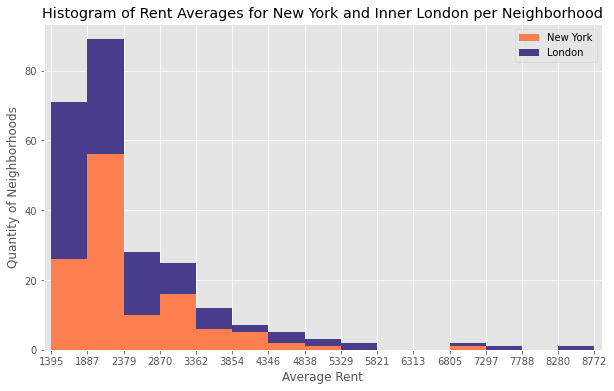

In [211]:
t_bins = 15

count, bin_edges = np.histogram(rent_graph, t_bins)
xmin = bin_edges[0] - 100   
xmax = bin_edges[-1] + 100 


rent_graph.plot(kind='hist',
          figsize=(10, 6), 
          bins=t_bins,
          xticks=bin_edges,
          color=['coral', 'darkslateblue'],
          stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Histogram of Rent Averages for New York and Inner London per Neighborhood')
plt.ylabel('Quantity of Neighborhoods')
plt.xlabel('Average Rent') 

plt.show()

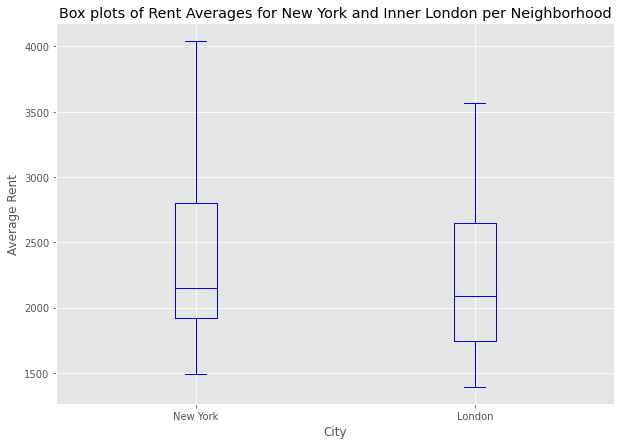

In [254]:
rent_graph.plot(kind='box',
                figsize=(10, 7),
                color='blue',
                vert=True,
                stacked = True,
                showfliers =False
                )

  
plt.title('Box plots of Rent Averages for New York and Inner London per Neighborhood')
  

plt.ylabel('Average Rent')
plt.xlabel('City')
plt.show()


plt.show()

#### We enter our Foursquare credentials.

In [ ]:
CLIENT_ID = input("Enter Foursquare CLIENT ID: ") # Foursquare ID
CLIENT_SECRET = input("Enter Foursquare CLIENT SECRET: ") # Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### We create a function that looks for the first venues within a given radius and of a certain latitude and longitude, and with a limit of results.

In [38]:
def getNearbyVenues(names, latitudes, longitudes, city, rent, LIMIT, radius=500):
    
    venues_list=[]
    for name, lat, lng, c, r in zip(names, latitudes, longitudes, city, rent):
        print(name,",", c)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            c,
            r,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  "City",
                  "Rent for Two-bedroom", 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now, we simply run the function with the data in the dataframe with the neighbourhoods of New York and London.

In [39]:
limit = 100

ny_lon_venues = getNearbyVenues(names=ny_lon_df['Neighborhood'],
                                   latitudes=ny_lon_df['Latitude'],
                                   longitudes=ny_lon_df['Longitude'],
                                   city=ny_lon_df["City"],
                                   rent=ny_lon_df["Rent for Two-bedroom"],
                                   LIMIT = limit
                                  )

Astoria , New York
Auburndale , New York
Bath Beach , New York
Battery Park City , New York
Bay Ridge , New York
Baychester , New York
Bayside , New York
Bedford Park , New York
Bellerose , New York
Belmont , New York
Bensonhurst , New York
Bergen Beach , New York
Boerum Hill , New York
Borough Park , New York
Briarwood , New York
Brighton Beach , New York
Brooklyn Heights , New York
Brookville , New York
Brownsville , New York
Bushwick , New York
Cambria Heights , New York
Canarsie , New York
Carroll Gardens , New York
Castle Hill , New York
Central Harlem , New York
Chelsea , New York
Chelsea , New York
Chinatown , New York
City Island , New York
Civic Center , New York
Clinton Hill , New York
Co-op City , New York
Cobble Hill , New York
College Point , New York
Concourse , New York
Coney Island , New York
Country Club , New York
Crown Heights , New York
Ditmas Park , New York
Douglaston , New York
Dyker Heights , New York
East Elmhurst , New York
East Flatbush , New York
East Harlem

#### We inspect the resulting dataframe.

In [40]:
ny_lon_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,City,Rent for Two-bedroom,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Astoria,40.768509,-73.915657,New York,2273.0,Favela Grill,40.767348,-73.917897,Brazilian Restaurant
1,Astoria,40.768509,-73.915657,New York,2273.0,Orange Blossom,40.769856,-73.917012,Gourmet Shop
2,Astoria,40.768509,-73.915657,New York,2273.0,Simply Fit Astoria,40.769114,-73.912403,Gym
3,Astoria,40.768509,-73.915657,New York,2273.0,Titan Foods Inc.,40.769198,-73.919253,Gourmet Shop
4,Astoria,40.768509,-73.915657,New York,2273.0,Off The Hook,40.767200,-73.918104,Seafood Restaurant


#### Are there any duplicate venues?

In [41]:
print("There are {} duplicated venues".format(ny_lon_venues[ny_lon_venues.duplicated()].shape[0]))

There are 0 duplicated venues


#### Now that we know that all venues are unique, how many do we have?

In [42]:
print("There are {} unique venues".format(ny_lon_venues.shape[0]))
print("There are {} unique venues in Manhattan".format(ny_lon_venues[ny_lon_venues["City"] == "New York"].shape[0]))
print("There are {} unique venues in London".format(ny_lon_venues[ny_lon_venues["City"] == "London"].shape[0]))

There are 18614 unique venues
There are 9983 unique venues in Manhattan
There are 8631 unique venues in London


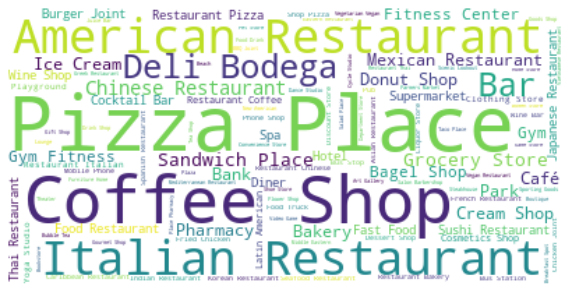

In [413]:
def listToString(s):  
    
    str1 = " " 
    
 
    return (str1.join(s)) 

ny_venues_str = listToString(ny_lon_venues[ny_lon_venues["City"] == "New York"]["Venue Category"])

ny_venue_wc = WordCloud(background_color='white')


ny_venue_wc.generate(ny_venues_str)

plt.figure(figsize=(10,6))
plt.imshow(ny_venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

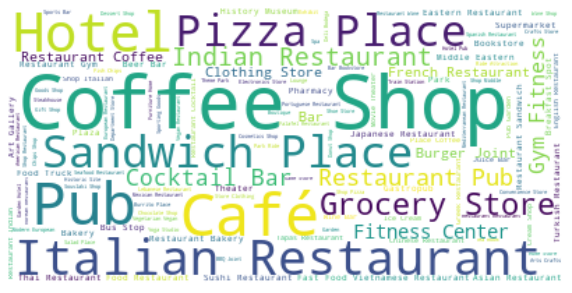

In [414]:
lon_venues_str = listToString(ny_lon_venues[ny_lon_venues["City"] == "London"]["Venue Category"])

lon_venue_wc = WordCloud(background_color='white')


lon_venue_wc.generate(lon_venues_str)

plt.figure(figsize=(10,6))
plt.imshow(lon_venue_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#### We group the dataframe by Neighborhood to see how many venues we have in each one.

In [43]:
ny_lon_venues.groupby('Neighborhood').count().head(10)

,Neighborhood Latitude,Neighborhood Longitude,City,Rent for Two-bedroom,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,,
Annadale,11,11,11,0,11,11,11,11
Arden Heights,5,5,5,0,5,5,5,5
Arlington,6,6,6,0,6,6,6,6
Arrochar,22,22,22,0,22,22,22,22
Arverne,20,20,20,0,20,20,20,20
Astoria,100,100,100,100,100,100,100,100
Astoria Heights,13,13,13,0,13,13,13,13
Auburndale,22,22,22,22,22,22,22,22
Bath Beach,47,47,47,47,47,47,47,47


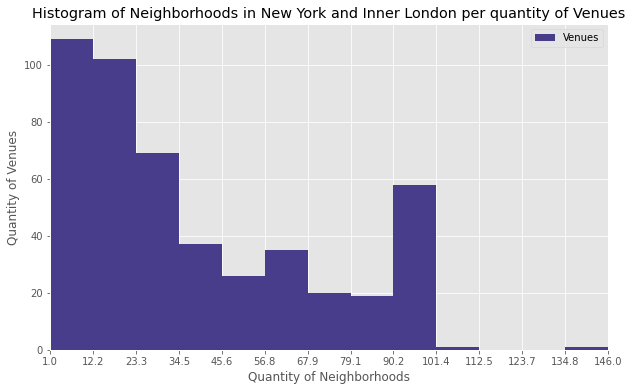

In [394]:
t_bins = 13

nr_venues = ny_lon_venues.groupby('Neighborhood').count().drop(nr_venues.columns[1::],axis=1)
nr_venues.rename(columns={"Neighborhood Latitude":"Venues"},inplace=True)


count, bin_edges = np.histogram(nr_venues, t_bins)
xmin = bin_edges[0]   
xmax = bin_edges[-1] 

# stacked Histogram
nr_venues.plot(kind='hist',
          figsize=(10, 6), 
          bins=t_bins,
          xticks=bin_edges,
          color=['darkslateblue'],
          #stacked=True,
          xlim=(xmin, xmax)
         )

plt.title('Histogram of Neighborhoods in New York and Inner London per quantity of Venues')
plt.ylabel('Quantity of Venues')
plt.xlabel('Quantity of Neighborhoods') 

plt.show()

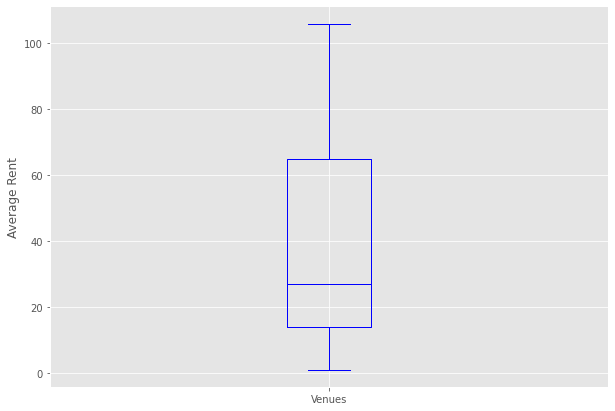

In [397]:
nr_venues.plot(kind='box',
                figsize=(10, 7),
                color='blue',
                vert=True,
                stacked = True,
                showfliers =False
                )

  
plt.title('Boxplot of of Neighborhoods in New York and Inner London per quantity of Venues')
plt.ylabel('Average Rent')
plt.show()

plt.show()

#### How many unique categories do we have?

In [44]:
print('There are {} uniques categories.'.format(len(ny_lon_venues['Venue Category'].unique())))

There are 483 uniques categories.


#### We can say we have enough data, so we create dummy columns with each category, and we put Neighborhood as the first column.

In [45]:
# one hot encoding
ny_lon_onehot = pd.get_dummies(ny_lon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_lon_onehot['Neighborhood'] = ny_lon_venues['Neighborhood'] 

# move neighborhood column to the first column
ind_minus_neig = list(ny_lon_onehot.columns)
ind_minus_neig.remove("Neighborhood")

fixed_columns = ["Neighborhood"] + ind_minus_neig
ny_lon_onehot = ny_lon_onehot[fixed_columns]

ny_lon_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,...,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yoshoku Restaurant
0,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Astoria,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### We group rows by neighborhood and by mean of the frequency of occurrence of each category.

In [46]:
ny_lon_grouped = ny_lon_onehot.groupby('Neighborhood').mean().reset_index()
ny_lon_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,...,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Yoshoku Restaurant
0,Annadale,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.090909,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
1,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
2,Arlington,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
3,Arrochar,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045455,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
4,Arverne,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.050000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,Woodhaven,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040000,0.000000,0.080000,0.04,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0
473,Woodlawn,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

#### We create a function to sort venues by most appearences.

In [47]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### We create a dataframe with the top 10 venues per Neighborhood.

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ny_lon_grouped['Neighborhood']

for ind in np.arange(ny_lon_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ny_lon_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Pizza Place,American Restaurant,Diner,Dance Studio,Park,Restaurant,Deli / Bodega,Food,Train Station,Farmers Market
1,Arden Heights,Coffee Shop,Pizza Place,Pharmacy,Deli / Bodega,Bus Stop,Fabric Shop,Farmers Market,Farm,Falafel Restaurant,Factory
2,Arlington,Boat or Ferry,Grocery Store,Bus Stop,Deli / Bodega,Coffee Shop,Home Service,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
3,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Sandwich Place,Pharmacy,Mediterranean Restaurant,Pizza Place,Outdoors & Recreation,Liquor Store,Athletics & Sports
4,Arverne,Surf Spot,Metro Station,Sandwich Place,Beach,Playground,Bus Stop,Café,Board Shop,Thai Restaurant,Coffee Shop
...,...,...,...,...,...,...,...,...,...,...,...
472,Woodhaven,Deli / Bodega,Park,Pharmacy,Bank,Supermarket,Thai Restaurant,Mexican Restaurant,Sandwich Place,Bar,Bagel Shop
473,Woodlawn,Deli / Bodega,Pub,Bar,Pizza Place,Playground,Laundromat,Plaza,Park,Food & Drink Shop,Trail
474,Woodrow,Racetrack,Historic Site,Home Service,Intersection,Gym / Fitness Center,Falafel Restaurant,Factory,Fabric Shop,Eye Doctor,Yoshoku Restaurant
475,Woodside,Grocery Store,Bakery,Filipino Restaurant,Latin American Restaurant,Thai Restaurant,Bar,American Restaurant,Pub,Donut Shop,Pizza Place


#### How big is this dataframe?

In [49]:
print(neighborhoods_venues_sorted.shape)

(477, 11)


#### Let's check if it's the same size as the original dataframe.

In [50]:
print(ny_lon_df.shape[0])

481


#### We have to determine how many clusters we are going to use. One way is to check for different quantities and see which one returns the most heterogeneous clusters, citywise.

In [260]:
kclusters = 50
balan = np.zeros(kclusters)
balan2 = np.zeros(kclusters)

for k in range(1,kclusters):
  
  ny_lon_grouped_clustering = ny_lon_grouped.drop('Neighborhood', 1)

  # run k-means clustering
  kmeans = KMeans(n_clusters=k, random_state=0).fit(ny_lon_grouped_clustering)

  try:
    neighborhoods_venues_sorted.drop("Cluster Labels",axis = 1, inplace = True) #Drop a previously created "Cluster Labels" column, useful to try different number of clusters to find the optimal one
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
  except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

  ny_lon_merged = ny_lon_df.drop_duplicates()[list(ny_lon_df.drop_duplicates().isin(list(neighborhoods_venues_sorted["Neighborhood"]))["Neighborhood"])]  #We eliminate Neighborhoods that are not on both dataframes

  # merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
  ny_lon_merged = ny_lon_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

  aux = 0
  aux2 = 0
  for i in range(k):
    df_kc = ny_lon_merged[ny_lon_merged["Cluster Labels"] == i].groupby('City').count()
  
    if(df_kc.shape[0] == 2):
      aux += df_kc.iloc[0,0] + df_kc.iloc[1,0]


  balan[k] = aux/ny_lon_merged.shape[0]

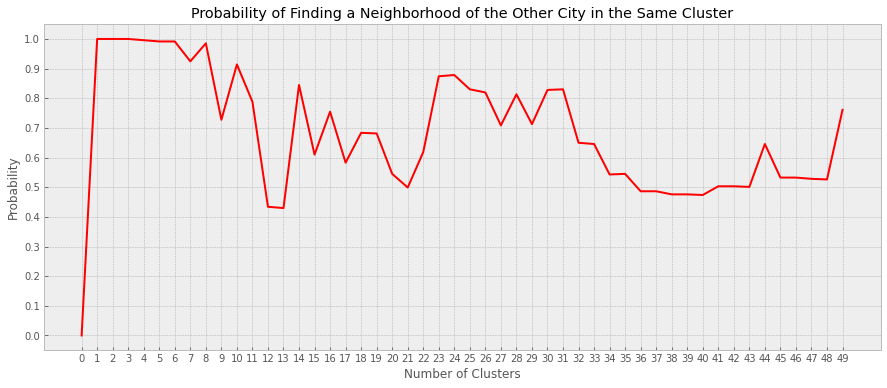

In [261]:
with plt.style.context("bmh"):
  fig = plt.figure(figsize = (15,6))

  plt.plot(balan, "r")
  ax = fig.gca()
  ax.set_xticks(np.arange(0, kclusters))
  ax.set_yticks(np.arange(0, 1.1, 0.1))

plt.title('Probability of Finding a Neighborhood of the Other City in the Same Cluster')
plt.ylabel('Probability')
plt.xlabel('Number of Clusters')
plt.show()

#### We find the number of clusters that maximise the probability, not counting the ones next to 1.

In [262]:
balan[0:20] = 0

kclusters = np.argmax(balan)
prob = round(balan.max()*100,2)

print("The number of clusters that maximise the probability is {}, with a probability of {}%".format(kclusters, prob))

The number of clusters that maximise the probability is 24, with a probability of 87.84%


#### As we can see, if we don't consider the small values because they will not give as much information, we get the maximum probability with 24 clusters. So we chose that value to divide each neighborhood into clusters.

In [263]:
# set number of clusters
ny_lon_grouped_clustering = ny_lon_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_lon_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([ 2, 20,  0, 15, 16, 16, 16, 16, 16,  7, 16, 16,  1, 16,  1,  5, 16,
       16, 15, 15, 15, 16,  7,  1, 16, 16,  2, 12, 20, 16, 20,  1, 16, 14,
        7,  2, 16,  6, 16,  7,  5, 16,  2,  2, 16,  5,  5, 16, 16,  1,  5,
        1,  7,  7,  5, 16,  7, 16,  1, 15,  1,  1, 16,  1,  2,  1,  1,  2,
        1, 16, 16, 16,  0,  3,  7,  0,  3, 23,  5,  3,  5,  5,  0, 16,  3,
        5,  3, 16,  0,  0,  0,  0,  0,  3,  3,  3,  3,  3,  3,  5,  5,  5,
        3,  3,  3,  3,  3,  5,  3,  5,  3,  3,  3,  5,  3,  3,  3,  3,  3,
        3,  1,  7, 16, 20,  2, 16, 16,  1, 20,  7, 15, 15, 15, 16,  2, 11,
        1, 16,  5,  1, 16,  1,  2,  1, 16,  1, 16, 16, 17,  7,  1, 16,  1,
       20, 16, 16, 18, 16,  2, 16, 15, 16,  7, 16, 20, 16,  2,  1,  7,  1,
        7,  1,  1,  1,  8,  1, 16,  1, 16, 16,  1, 16,  1,  1, 16,  2,  1,
        7, 16,  5, 15, 16,  1, 16, 16,  5,  1, 16, 15, 16,  0,  2, 16, 16,
        1,  1,  7, 15,  1,  1, 16, 16,  5, 16,  2,  2,  9, 16,  2,  2,  1,
        1,  1,  1, 16,  3

#### To check if we chose a number of clusters that is good enough, we see how many neighborhoods of each city are assigned in each cluster

In [498]:
graph_cluster = pd.DataFrame(columns=["Cluster Type","Neighborhoods"])
graph_cluster["Cluster Type"] = ["One", "Both"]
graph_cluster["Neighborhoods"] = np.zeros(2)
graph_cluster.set_index("Cluster Type", inplace=True)

for i in range(kclusters):
  df_kc = ny_lon_merged[ny_lon_merged["Cluster Labels"] == i].groupby('City').count()

  if(df_kc.shape[0] == 2):
    print(i, df_kc.iloc[[0,1],0])
    graph_cluster.at["Both","Neighborhoods"] = graph_cluster.at["Both","Neighborhoods"] + df_kc.iloc[0,0] + df_kc.iloc[1,0]

  else:
    print(i, df_kc.shape[0])
    graph_cluster.at["One","Neighborhoods"] = graph_cluster.at["One","Neighborhoods"] + df_kc.shape[0]

0 City
London      1
New York    2
Name: Neighborhood, dtype: int64
1 City
London      32
New York     7
Name: Neighborhood, dtype: int64
2 1
3 1
4 City
London      67
New York     1
Name: Neighborhood, dtype: int64
5 1
6 City
London      21
New York    68
Name: Neighborhood, dtype: int64
7 1
8 1
9 1
10 1
11 1
12 City
London       1
New York    60
Name: Neighborhood, dtype: int64
13 1
14 1
15 City
London       2
New York    10
Name: Neighborhood, dtype: int64
16 1
17 1
18 1
19 1
20 City
London      6
New York    6
Name: Neighborhood, dtype: int64
21 1
22 1
23 1


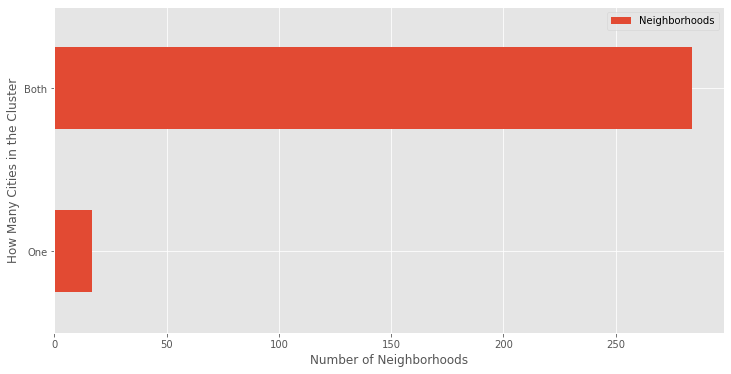

In [499]:
graph_cluster.plot(kind="barh",
                   figsize=(12,6))

plt.title('Neighborhoods in Clusters')
plt.ylabel('How Many Cities in the Cluster')
plt.xlabel('Number of Neighborhoods')
plt.show()

#### Finally, we assigne each cluster number to the corresponding neighborhood and we put all the data we have into one dataframe.

In [501]:
try:
  neighborhoods_venues_sorted.drop("Cluster Labels",axis = 1, inplace = True) #Drop a previously created "Cluster Labels" column, useful to try different number of clusters to find the optimal one
  neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
except:
  neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

ny_lon_df.drop_duplicates(subset="Neighborhood", inplace=True)

ny_lon_merged = ny_lon_df.merge(neighborhoods_venues_sorted, on="Neighborhood")

ny_lon_merged.head(10)

,Neighborhood,Rent for Two-bedroom,Longitude,Latitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Astoria,2273.0,-73.9157,40.7685,New York,16,Middle Eastern Restaurant,Bar,Indian Restaurant,Greek Restaurant,Seafood Restaurant,Hookah Bar,Pizza Place,Mediterranean Restaurant,Bakery,Café
1,Auburndale,1971.0,-73.7918,40.7617,New York,16,Italian Restaurant,Furniture / Home Store,Athletics & Sports,Gymnastics Gym,Toy / Game Store,Pet Store,Pharmacy,Train,Bar,Miscellaneous Shop
2,Bath Beach,1781.0,-73.9987,40.5995,New York,16,Pharmacy,Dessert Shop,Chinese Restaurant,Bubble Tea Shop,Donut Shop,Fast Food Restaurant,Cantonese Restaurant,Pizza Place,Gas Station,Italian Restaurant
3,Battery Park City,4645.0,-74.0169,40.7119,New York,7,Park,Hotel,Gym,Coffee Shop,Memorial Site,Food Court,Shopping Mall,Burger Joint,Gourmet Shop,Boat or Ferry
4,Bay Ridge,1963.0,-74.0306,40.6258,New York,16,Italian Restaurant,Pizza Place,Spa,Greek Restaurant,American Restaurant,Bar,Playground,Sushi Restaurant,Mexican Restaurant,Café
5,Baychester,NaN,-73.8358,40.8669,New York,1,Donut Shop,Food & Drink Shop,Discount Store,Men's Store,Mattress Store,Gym / Fitness Center,Mexican Restaurant,Electronics Store,Pet Store,Bank
6,Bayside,2100.0,-73.7743,40.766,New York,16,Bar,Pizza Place,Indian Restaurant,Sushi Restaurant,Chinese Restaurant,American Restaurant,Greek Restaurant,Bakery,Spa,Pub
7,Bedford Park,1708.0,-73.8855,40.8702,New York,1,Diner,Pizza Place,Chinese Restaurant,Mexican Restaurant,Pharmacy,Sandwich Place,Deli / Bodega,Spanish Restaurant,Supermarket,Donut Shop
8,Bellerose,NaN,-73.7201,40.7286,New York,15,Deli / Bodega,Italian Restaurant,Motel,Seafood Restaurant,Bank,Salon / Barbershop,Pizza Place,Gym,Mobile Phone Shop,Gas Station
9,Belmont,2030.0,-73.8885,40.8573,New York,15,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Donut Shop,Bank,Food & Drink Shop,Spanish Restaurant,Café


#### We assigne a color to each cluster, to diferentiate them on the map.

In [496]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

#### We show the same maps of New York and London we did previously, but with the cluster colors on each neighborhood.

In [537]:
map_clusters_ny = folium.Map(location=[latitude_ny, longitude_ny], zoom_start=11)

ny_merged = ny_lon_merged[ny_lon_merged["City"] == "New York"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rent in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['Neighborhood'], ny_merged['Cluster Labels'], ny_merged['Rent for Two-bedroom']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + " Rent " + str(rent), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

In [538]:
map_clusters_lon = folium.Map(location=[latitude_lon, longitude_lon], zoom_start=11.5)

lon_merged = ny_lon_merged[ny_lon_merged["City"] == "London"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, rent in zip(lon_merged['Latitude'], lon_merged['Longitude'], lon_merged['Neighborhood'], lon_merged['Cluster Labels'], lon_merged['Rent for Two-bedroom']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + " Rent " + str(rent), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_lon)
       
map_clusters_lon

#### We replace the NaN for -1 to making it easier to manipulate.

In [449]:
ny_lon_merged.fillna(-1, inplace=True)

#### Now that all the data is processed, the user can input their neighborhood. We show all the data we have about that particular neighborhood. If the input is not valid, we return an error message.

In [468]:
in_neigh = input("Where do you live?: ")

no_neigh = 0
while(no_neigh == 0):
  try:
    df_neigh = ny_lon_merged[ny_lon_merged["Neighborhood"] == in_neigh].reset_index()

    in_cluster = df_neigh.loc[0,"Cluster Labels"]
    in_rent = df_neigh.loc[0,"Rent for Two-bedroom"]
    in_city = df_neigh.loc[0,"City"]

    if(in_rent != -1):
      print("Your neighborhood is {} in {}, with an average rent of ${}".format(in_neigh, in_city, int(in_rent)))
    else:
      print("Your neighborhood is {} in {}, we don't have information about the rent in that area".format(in_neigh, in_city, int(in_rent)))    

    no_neigh = 1

  except:
    in_neigh = input("Invalid neighborhood, please try again: ")

Where do you live?: Belmont
Your neighborhood is Belmont in New York, with an average rent of $2030


#### Let's see where the neighborhood is.

In [541]:
if(in_city == "New York"):
  latitude_in = latitude_ny
  longitude_in = longitude_ny
else:
  latitude_in = latitude_lon
  longitude_in = longitude_lon


map_clusters_in = folium.Map(location=[latitude_in, longitude_in], zoom_start=11.5)

in_merged = ny_lon_merged[ny_lon_merged["Neighborhood"] == in_neigh]

# add markers to the map
markers_colors = []
label = folium.Popup(str(in_neigh) + ' Cluster ' + str(list(in_merged['Cluster Labels'])[0]) + " Rent " + str(in_rent), parse_html=True)
folium.CircleMarker(
        [list(in_merged['Latitude'])[0], list(in_merged['Longitude'])[0]],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color=rainbow[list(in_merged['Cluster Labels'])[0]-1],
        fill_opacity=0.7).add_to(map_clusters_in)


       
map_clusters_in

#### Let's see all the neighborhoods in that cluster.

In [469]:
df_kc = ny_lon_merged[ny_lon_merged["Cluster Labels"] == in_cluster].reset_index(drop=True).drop(["Longitude", "Latitude"], axis=1)
df_kc.head()

,Neighborhood,Rent for Two-bedroom,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bellerose,-1.0,New York,38,Deli / Bodega,Italian Restaurant,Motel,Seafood Restaurant,Bank,Salon / Barbershop,Pizza Place,Gym,Mobile Phone Shop,Gas Station
1,Belmont,2030.0,New York,38,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Donut Shop,Bank,Food & Drink Shop,Spanish Restaurant,Café
2,Throgs Neck,2051.0,New York,38,Italian Restaurant,Coffee Shop,Mobile Phone Shop,Asian Restaurant,Bar,Chinese Restaurant,Sports Bar,Pizza Place,American Restaurant,Deli / Bodega
3,Edgewater Park,-1.0,New York,38,Italian Restaurant,Coffee Shop,Pizza Place,Deli / Bodega,Sports Bar,Bar,Asian Restaurant,Spa,Donut Shop,Ice Cream Shop
4,New Dorp,-1.0,New York,38,Italian Restaurant,Pizza Place,Gas Station,Dim Sum Restaurant,Bank,Sushi Restaurant,Hobby Shop,Salon / Barbershop,Taco Place,Sandwich Place


In [470]:
df_kc[df_kc["Neighborhood"] == in_neigh]

,Neighborhood,Rent for Two-bedroom,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Belmont,2030.0,New York,38,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Donut Shop,Bank,Food & Drink Shop,Spanish Restaurant,Café


#### We chose the ones that are not in the city of the input neighborhood. If there are none, an error message is returned.

In [471]:
df_kc = df_kc[df_kc["City"] != in_city].reset_index(drop=True)

if(df_kc.shape[0] == 0):
  print("There are no neighborhoods that can be compared to yours")

df_kc.head()

,Neighborhood,Rent for Two-bedroom,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,N21,1723.0,London,38,Italian Restaurant,Bar,Bus Stop,Deli / Bodega,Pub,Supermarket,Bistro,Middle Eastern Restaurant,Train Station,Coffee Shop


#### We sort the dataframe we got by rent rate.

In [472]:
df_kc = df_kc.astype({"Rent for Two-bedroom":"int32"})
df_kc=df_kc.sort_values('Rent for Two-bedroom').reset_index(drop=True)

df_kc.head()

,Neighborhood,Rent for Two-bedroom,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,N21,1723,London,38,Italian Restaurant,Bar,Bus Stop,Deli / Bodega,Pub,Supermarket,Bistro,Middle Eastern Restaurant,Train Station,Coffee Shop


#### We find the position the rent rate of the input neighborhood has, and we chose the next smaller one. We return the information we have of the neighborhood to the user.

In [473]:
loc_ind = np.searchsorted(list(df_kc['Rent for Two-bedroom']),in_rent, side="left")

if(loc_ind == df_kc.shape[0] - 1):
  loc_ind = loc_ind-1
elif(loc_ind == 0):
  loc_ind = loc_ind+1
elif(df_kc.loc[loc_ind-1,"Rent for Two-bedroom"] == -1):
  loc_ind = loc_ind+1
else:
  loc_ind = loc_ind-1




out_neigh = df_kc.loc[loc_ind,"Neighborhood"]
out_city = df_kc.loc[loc_ind,"City"]
out_rent = df_kc.loc[loc_ind,"Rent for Two-bedroom"]

if(out_rent != -1):
  print("The most similar Neighbourhood in the city of {} is {}, with an average rent of ${}".format(out_city, out_neigh, out_rent)) 
else:
  print("The most similar Neighbourhood in the city of {} is {}. We don't have information about rents in that area".format(out_city, out_neigh))

The most similar Neighbourhood in the city of London is N21, with an average rent of $1723


#### Let's see the output neighborhood in detail.

In [474]:
df_kc[df_kc["Neighborhood"] == out_neigh]

,Neighborhood,Rent for Two-bedroom,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,N21,1723,London,38,Italian Restaurant,Bar,Bus Stop,Deli / Bodega,Pub,Supermarket,Bistro,Middle Eastern Restaurant,Train Station,Coffee Shop


#### And its location.

In [543]:
if(out_city == "New York"):
  latitude_out = latitude_ny
  longitude_out = longitude_ny
else:
  latitude_out = latitude_lon
  longitude_out = longitude_lon


map_clusters_out = folium.Map(location=[latitude_out, longitude_out], zoom_start=11)

out_merged = ny_lon_merged[ny_lon_merged["Neighborhood"] == out_neigh]

# add markers to the map
markers_colors = []
label = folium.Popup(str(out_neigh) + ' Cluster ' + str(list(out_merged['Cluster Labels'])[0]) + " Rent " + str(out_rent), parse_html=True)
folium.CircleMarker(
        [list(out_merged['Latitude'])[0], list(out_merged['Longitude'])[0]],
        radius=5,
        popup=label,
        color="black",
        fill=True,
        fill_color=rainbow[list(out_merged['Cluster Labels'])[0]-1],
        fill_opacity=0.7).add_to(map_clusters_out)


       
map_clusters_out